In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Preprocess Pipeline

In [2]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np


# These are length cols so their values must be 0 or +ve
cols_non_negative = ['tcp_time_delta', 'tcp_len', 'mqtt_len', 'mqtt_proto_len', 'mqtt_willmsg_len', 'mqtt_willtopic_len']

# nominal_cols = ['tcp_flags', 'mqtt_conack_flags', 'mqtt_conflags', 'mqtt_hdrflags']
# The other 2 are not useful --> (for more than 99% of the entries, they are 0)
# mqtt_hdrflags --> 37% of the entries are not in hex format but we will 1 hot encode it
nominal_cols = ['tcp_flags', 'mqtt_hdrflags']

continous_cols = ['tcp_time_delta', 'tcp_len', 'mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp',\
                'mqtt_conflag_cleansess', 'mqtt_conflag_passwd', 'mqtt_conflag_qos', 'mqtt_conflag_reserved', \
                'mqtt_conflag_retain', 'mqtt_conflag_uname', 'mqtt_conflag_willflag', 'mqtt_dupflag', \
                'mqtt_kalive', 'mqtt_len', 'mqtt_msg', 'mqtt_msgid', 'mqtt_msgtype', 'mqtt_proto_len', \
                'mqtt_qos', 'mqtt_retain', 'mqtt_sub_qos', 'mqtt_suback_qos', 'mqtt_willmsg', \
                'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len', 'mqtt_ver', 'mqtt_conack_val']

def convert_string(s):
    return 0 if s == '0' else 1

def convert_target_to_label(target):
    if target == 'slowite':
        return 0
    elif target == 'bruteforce':
        return 1
    elif target == 'flood':
        return 2
    elif target == 'malformed':
        return 3
    elif target == 'dos':
        return 4
    elif target == 'legitimate':
        return 5
    else:
        return 6
    
class RenameDatasetCols(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        all_cols = output_df.columns
        for column in all_cols:
            new_column = column.replace('.', '_')
            output_df = output_df.withColumnRenamed(column, new_column)
        # print(output_df.columns)
        return output_df

class OutcomeCreator(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_classes = udf(convert_target_to_label, IntegerType())
        output_df = dataset.withColumn('label', label_to_classes(dataset['target'])).drop('target')
        output_df = output_df.withColumn('label', output_df['label'].cast(DoubleType()))
        return output_df
    
class ConstraintChecker(Transformer):
    def __init__(self, columns_to_check = None):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in cols_non_negative:
            output_df = output_df.filter(output_df[col_name] >= 0)
        return output_df
    
class ColumnDropper(Transformer):
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop = columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            if col_name in output_df.columns:
                output_df = output_df.drop(col_name)
        return output_df
    
def get_preprocess_pipeline():

    # Stage where we rename the columns
    stage_column_renamer = RenameDatasetCols()

    # Stage where we handle nominal values
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continous_cols + nominal_onehot_cols

    # These cols have only 1 unique value
    cols_single_val = ['mqtt_conack_flags_reserved', 'mqtt_conack_flags_sp', 'mqtt_conflag_qos', \
                       'mqtt_conflag_reserved', 'mqtt_conflag_retain', 'mqtt_conflag_willflag', 'mqtt_sub_qos', \
                        'mqtt_suback_qos', 'mqtt_willmsg', 'mqtt_willmsg_len', 'mqtt_willtopic', 'mqtt_willtopic_len']
    
    # Highly correlaterd columns
    cols_high_corr = ['mqtt_conflag_cleansess', 'mqtt_proto_len', 'mqtt_conflag_passwd', 'mqtt_len']
    
    # Not useful columns
    cols_not_useful = ['mqtt_msg']

    # These are supposed to be in form 0x0000XX but > 99% are 0
    cols_hex_constraints_not_met = ['mqtt_conack_flags', 'mqtt_conflags']

    # > 99% of the entries are 0
    cols_more_than_99_zero = ['mqtt_conack_val', 'mqtt_conflag_uname', 'mqtt_kalive', 'mqtt_protoname', 'mqtt_retain', 'mqtt_ver']
    
    cols_to_remove = cols_single_val + cols_high_corr + cols_not_useful + cols_hex_constraints_not_met + nominal_cols\
                     + nominal_id_cols + cols_more_than_99_zero
    
    for col_name in cols_to_remove:
        if col_name in feature_cols:
            feature_cols.remove(col_name)

    print(feature_cols)
    # Stage where we assemble all the features into a vector

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol='vectorized_features')

    # Stage where we scale the features
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

    # Stage where we create the label column
    stage_label_creator = OutcomeCreator()

    # Removing all unnecessary columns, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = continous_cols + ['vectorized_features'] + nominal_cols\
                                         + nominal_id_cols + nominal_onehot_cols + cols_to_remove)

    # Connecting the columns into a pipeline
    pipeline = Pipeline(stages = [stage_column_renamer, stage_nominal_indexer,\
                                   stage_nominal_onehot_encoder, stage_vector_assembler, stage_scaler,\
                                      stage_label_creator, stage_column_dropper])
    
    return pipeline    

In [3]:
# Uncomment the following lines if you are using Windows!
# import findspark
# findspark.init()
# findspark.find()

import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)\
    .set('spark.jars', 'gs://dataproc-staging-us-central1-159964990471-2n8oqiw8/postgresql-42.6.0.jar')


# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

mqtt_train_raw = spark.read.csv("gs://dataproc-staging-us-central1-159964990471-2n8oqiw8/train70_reduced.csv" ,header=True, inferSchema= True)
mqtt_test_raw = spark.read.csv("gs://dataproc-staging-us-central1-159964990471-2n8oqiw8/test30_reduced.csv", header=True, inferSchema=True)

# preprocess_pipeline = get_preprocess_pipeline()
# preprocess_pipeline_model = preprocess_pipeline.fit(mqtt_train_raw)

# mqtt_train_df = preprocess_pipeline_model.transform(mqtt_train_raw)
# mqtt_test_df = preprocess_pipeline_model.transform(mqtt_test_raw)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/16 19:33:31 INFO SparkEnv: Registering MapOutputTracker
23/11/16 19:33:31 INFO SparkEnv: Registering BlockManagerMaster
23/11/16 19:33:31 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/11/16 19:33:31 INFO SparkEnv: Registering OutputCommitCoordinator
/usr/lib/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
from pyspark.sql.functions import lit

mqtt_train_raw = mqtt_train_raw.withColumn('Train', lit(1))
mqtt_test_raw = mqtt_test_raw.withColumn('Train', lit(0))

### Loading data from postgres on cloud

In [5]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="18763kebjeseaya"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://34.136.81.58/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt"


mqtt_train_raw.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

mqtt_test_raw.write.format("jdbc")\
.mode("append")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

23/11/16 19:33:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df.show(1, vertical=True)

-RECORD 0--------------------------------
 tcp.flags                  | 0x00000018 
 tcp.time_delta             | 0.998867   
 tcp.len                    | 10         
 mqtt.conack.flags          | 0          
 mqtt.conack.flags.reserved | 0.0        
 mqtt.conack.flags.sp       | 0.0        
 mqtt.conack.val            | 0.0        
 mqtt.conflag.cleansess     | 0.0        
 mqtt.conflag.passwd        | 0.0        
 mqtt.conflag.qos           | 0.0        
 mqtt.conflag.reserved      | 0.0        
 mqtt.conflag.retain        | 0.0        
 mqtt.conflag.uname         | 0.0        
 mqtt.conflag.willflag      | 0.0        
 mqtt.conflags              | 0          
 mqtt.dupflag               | 0.0        
 mqtt.hdrflags              | 0x00000030 
 mqtt.kalive                | 0.0        
 mqtt.len                   | 8.0        
 mqtt.msg                   | 32         
 mqtt.msgid                 | 0.0        
 mqtt.msgtype               | 3.0        
 mqtt.proto_len             | 0.0 

### Passing through Pipeline

In [7]:
mqtt_train_raw = df.filter(df.Train == 1)
mqtt_test_raw = df.filter(df.Train == 0)

#dropping the train column
mqtt_train_raw = mqtt_train_raw.drop('Train')
mqtt_test_raw = mqtt_test_raw.drop('Train')

In [8]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(mqtt_train_raw)

mqtt_train_df = preprocess_pipeline_model.transform(mqtt_train_raw)
mqtt_test_df = preprocess_pipeline_model.transform(mqtt_test_raw)

['tcp_time_delta', 'tcp_len', 'mqtt_dupflag', 'mqtt_msgid', 'mqtt_msgtype', 'mqtt_qos', 'tcp_flags_encoded', 'mqtt_hdrflags_encoded']


In [9]:
print(mqtt_train_df.count())
print(mqtt_test_df.count())

mqtt_train_df, mqtt_val_df = mqtt_train_df.randomSplit([0.8, 0.2], seed=42)
print('-------------------------')
print(mqtt_train_df.count())
print(mqtt_val_df.count())
print(mqtt_test_df.count())

# to find how many records of each label are there

mqtt_train_df.groupBy('label').count().orderBy("label").show()

231646
99290
-------------------------


185060


46586
99290


+-----+-----+
|label|count|
+-----+-----+
|  0.0| 5136|
|  1.0| 8092|
|  2.0|  345|
|  3.0| 6106|
|  4.0|72697|
|  5.0|92684|
+-----+-----+



### PyTorch Models

In [10]:
# find the number of inputs for neural netwrok

num_inputs = len(mqtt_train_df.select('features').first()[0])
num_inputs

26

In [11]:
!pip install torch

  Using cached torch-2.1.1-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
Using cached torch-2.1.1-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x8

In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Takes in a list of hidden layers and returns a PyTorch Sequential model
class NN(nn.Module):
    def __init__(self, N_in = 26, hidden_layers = [32, 32], N_out = 6):
        super().__init__()
        layers = []
        layers.append(nn.Linear(N_in, hidden_layers[0]))
        layers.append(nn.ReLU())

        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_layers[-1], N_out))
        self.seq = nn.Sequential(*layers)

    def forward(self, x):
        return self.seq(x)

class MQTTDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


In [13]:
mqtt_train_df_pandas = mqtt_train_df.toPandas()
mqtt_val_df_pandas = mqtt_val_df.toPandas()
mqtt_test_df_pandas = mqtt_test_df.toPandas()

X_train = torch.from_numpy(np.array(mqtt_train_df_pandas['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(mqtt_train_df_pandas['label'].values.tolist(), np.float32))

X_val = torch.from_numpy(np.array(mqtt_val_df_pandas['features'].values.tolist(), np.float32))
y_val = torch.from_numpy(np.array(mqtt_val_df_pandas['label'].values.tolist(), np.float32))

X_test = torch.from_numpy(np.array(mqtt_test_df_pandas['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(mqtt_test_df_pandas['label'].values.tolist(), np.float32))

train_dataset = MQTTDataset(X_train, y_train)
val_dataset = MQTTDataset(X_val, y_val)
test_dataset = MQTTDataset(X_test, y_test)

In [14]:
import matplotlib.pyplot as plt

def train_NN(model, train_dataset, val_dataset, lr=1e-4, batch_size=32, epochs = 15, verbose = True, plot = True, onGPU = False):

    """
    This function takes in a PyTorch Neural Network model, along with train and val datasets,
    trains the model and returns the trained model. It also saves the model with the best validation accuracy.

    Verbose and Graph options can be turned off if epoch progress and loss curves are not needed.

    onGPU option can be turned on if you want to train the model on GPU (if available).
    """
    # Setting up the parameters
    lr = lr
    batch_size = batch_size
    epochs = epochs

    # Setting up the dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Setting up the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adamax(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    current_best_val_accuracy = 0.0
    curr_best_model = None

    # Moving the model to GPU if available
    if onGPU:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)

    for epoch in range(epochs):
        train_batch_losses = []
        train_batch_accuracies = []
        for batch_id, (x_batch, y_batch) in enumerate(train_dataloader):
            model.train()

            # Moving the train data to GPU if available
            if onGPU:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch.long())

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_batch_losses.append(loss.item())
            prediction_label = torch.argmax(pred, dim = 1)
            train_batch_accuracies.append((prediction_label == y_batch).float().mean().item())

        val_batch_losses = []
        val_batch_accuracies = []
        with torch.no_grad():
            model.eval()
            for batch_id, (x_batch, y_batch) in enumerate(val_dataloader):

                # Moving the val data to GPU if available
                if onGPU:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch.long())

                val_batch_losses.append(loss.item())
                prediction_label = torch.argmax(pred, dim = 1)
                val_batch_accuracies.append((prediction_label == y_batch).float().mean().item())
        
        train_losses.append(np.mean(train_batch_losses))
        train_accuracies.append(np.mean(train_batch_accuracies))
        val_losses.append(np.mean(val_batch_losses))
        val_accuracies.append(np.mean(val_batch_accuracies))

        if verbose:
            print(f'Epoch {epoch} --- Training loss: {train_losses[-1]} --- Validation loss: {val_losses[-1]}')
            print(f'Training accuracy: {np.round(100*train_accuracies[-1],2)}% --- Validation accuracy: {np.round(100*val_accuracies[-1],2)}%')

        if val_accuracies[-1] > current_best_val_accuracy:
            if verbose:
                print(f'Current best val accuracy in this epoch')
                print(f'+----------------------------------------------------------+')
                print(f'|---------------------- Saving model ----------------------|')
                print(f'+----------------------------------------------------------+')
            current_best_val_accuracy = val_accuracies[-1]
            curr_best_model = model
            torch.save(model.state_dict(), 'best_model_shallow.pt')
            text = "Best Validation Accuracy: " + str(current_best_val_accuracy)
            with open('best_validation_shallow_NN.txt', 'w') as f:
                f.write(text)

    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

        ax[0].plot(train_losses, label='Training Loss')
        ax[0].plot(val_losses, label='Validation Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Losses vs Epoch')
        ax[0].legend()

        ax[1].plot(train_accuracies, label='Training Accuracy')
        ax[1].plot(val_accuracies, label='Validation Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_title('Accuracies vs Epoch')
        ax[1].legend()
    return curr_best_model

def evaluate_NN(model, test_dataset, batch_size = 32, verbose=True, onGPU = False):

    """
    This function takes in a trained PyTorch Neural Network model, along with a test dataset,
    evaluates the model and returns the test loss and accuracy.
    Model can be moved to GPU if available.
    """

    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    test_batch_losses = []
    test_batch_accuracies = []
    loss_fn = nn.CrossEntropyLoss()

    # Moving the model to GPU if available
    if onGPU:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)

    with torch.no_grad():
        model.eval()
        for batch_id, (x_batch, y_batch) in enumerate(test_dataloader):
            # Moving the test data to GPU if available
            if onGPU:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch.long())

            test_batch_losses.append(loss.item())
            prediction_label = torch.argmax(pred, dim = 1)
            test_batch_accuracies.append((prediction_label == y_batch).float().mean().item())

    if verbose:
        print(f'Test loss: {np.mean(test_batch_losses)}')
        print(f'Test accuracy: {np.round(100*np.mean(test_batch_accuracies),2)}%')

    return np.mean(test_batch_losses), np.mean(test_batch_accuracies)

### Shallow Neural Network (Untuned)

NN(
  (seq): Sequential(
    (0): Linear(in_features=26, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)
Epoch 0 --- Training loss: 0.8599632041603533 --- Validation loss: 0.522300142549224
Training accuracy: 75.3% --- Validation accuracy: 80.12%
Current best val accuracy in this epoch
+----------------------------------------------------------+
|---------------------- Saving model ----------------------|
+----------------------------------------------------------+
Epoch 1 --- Training loss: 0.4816581163050434 --- Validation loss: 0.4572341836436273
Training accuracy: 80.97% --- Validation accuracy: 81.59%
Current best val accuracy in this epoch
+----------------------------------------------------------+
|---------------------- Saving model ----------------------|
+----------------------------------------------------------+
Epoch 2 --- Training loss: 0.4494398219760811 --- Validation loss: 0.44211939356934565
Training accura

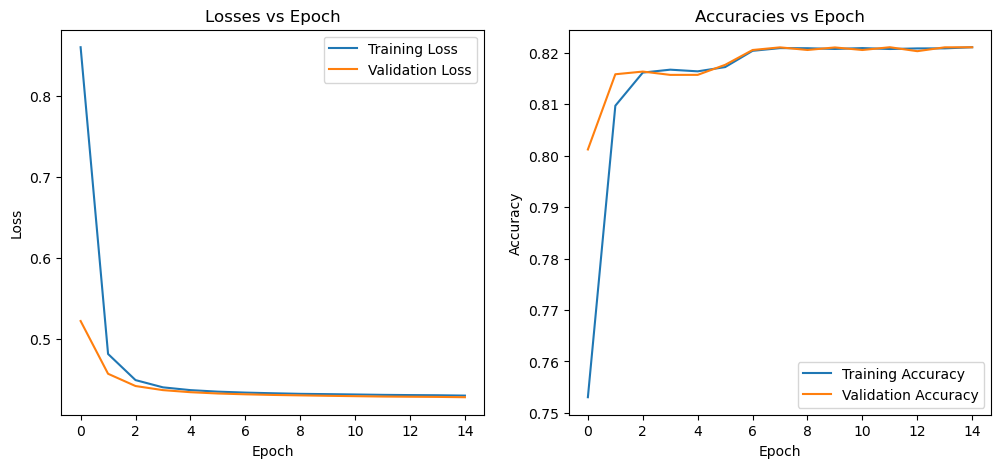

In [15]:
shallow_model = NN(hidden_layers=[32])
print(shallow_model)
shallow_model = train_NN(shallow_model, train_dataset, val_dataset)

In [16]:
evaluate_NN(shallow_model, test_dataset)

Test loss: 0.4437071200780741
Test accuracy: 82.0%


(0.4437071200780741, 0.8200314831741388)

### Tuning

### Shallow NN
1. I will be limiting the shallow neural network to 1 hidden layer.
2. Hyper-parameters: LR, epochs, batch size, hidden layer size

I will be tuning epochs and hidden layers. I will not be tuning lr as lr can help determine how fast the model converges but mainfocus here is to increase accuracy, as lr will be kept at default value (1e-4)

In [17]:
# epochs_list = [15, 25, 50]
# hidden_layers = [[32], [64], [128]]

epochs_list = [15]
hidden_layers = [[32]]

# curr_best_loss = 100
# curr_best_acc = 0

epochs_all = []
hidden_layers_all = []

loss_all = []
acc_all = []


for epochs in epochs_list:
    for hidden_layer in hidden_layers:
        print(f'epochs: {epochs}, hidden_layer: {hidden_layer}')
        model = NN(hidden_layers=hidden_layer)
        model = train_NN(model, train_dataset, val_dataset, epochs=epochs, verbose=False, plot=False, onGPU=True)
        loss, acc = evaluate_NN(model, test_dataset, verbose=False, onGPU=True)

        epochs_all.append(epochs)
        hidden_layers_all.append(hidden_layer)
        loss_all.append(loss)
        acc_all.append(acc)

        # clearing GPU cache
        torch.cuda.empty_cache()

epochs: 15, hidden_layer: [32]


In [18]:
# to find index in loss and acc with best loss and acc

best_loss_idx = np.argmin(loss_all)
best_acc_idx = np.argmax(acc_all)

print(f'Best accuracy: {acc_all[best_acc_idx]}')
print(f'Best hyperparameters: epochs: {epochs_all[best_acc_idx]}, hidden_layer: {hidden_layers_all[best_acc_idx]}')
print(f'----------------------------------------------------------------------------------------------')

print(f'Best loss: {loss_all[best_loss_idx]}')
print(f'Best hyperparameters: lr: epochs: {epochs_all[best_loss_idx]}, hidden_layer: {hidden_layers_all[best_loss_idx]}')

Best accuracy: 0.820067118664845
Best hyperparameters: epochs: 15, hidden_layer: [32]
----------------------------------------------------------------------------------------------
Best loss: 0.443507726158667
Best hyperparameters: lr: epochs: 15, hidden_layer: [32]


In [20]:
# loading the best model
best_model_shallow = NN(hidden_layers=[32])
best_model_shallow.load_state_dict(torch.load('best_model_shallow.pt'))
evaluate_NN(best_model_shallow, train_dataset, verbose=True, onGPU=True)

Test loss: 0.43018330285843476
Test accuracy: 82.11%


(0.43018330285843476, 0.8211283281466113)

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52092)
Traceback (most recent call last):
  File "/opt/conda/miniconda3/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/miniconda3/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/miniconda3/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/miniconda3/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/lib/spark/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.r